## BBM 409 - Programming Assignment 3

* You can add as many cells as you want in-between each question.
* Please add comments to your code to explain your work.  
* Please add Markdown cells to answer the (non-coding) questions in the homework text. You can, however, refer to the outputs of code cells without adding them as images to the Markdown cell unless you are requested to do otherwise.
* Please be careful about the order of runs of cells. Doing the homework, it is likely that you will be running the cells in different orders, however, they will be evaluated in the order they appear. Hence, please try running the cells in this order before submission to make sure they work.    
* Please refer to the homework text for any implementation detail. Though you are somewhat expected to abide by the comments in the below cells, they are mainly just provided for guidance. That is, as long as you are not completely off this structure and your work pattern is understandable and traceable, it is fine. For instance, you do not have to implement a particular function within a cell just because the comment directs you to do so.
* This document is also your report. Show your work.

Durmuş Selim Özçelik 2220356116

## 1. Implementing a CNN from Scratch (50 points)

### 1.1. Introduction
* Brief overview of the task.
* Answer the questions like, What are the main components of a CNN architecture?, Why we use this in image classification?, etc.
* Description of the dataset used for classification.

In this assignment, we are tasked with implementing a basic Convolutional Neural Network (CNN) using PyTorch for image classification. The objective is to construct a CNN architecture with 5 convolutional layers and a fully connected layer. The model will be trained on a subset of the Animals-10 Dataset, which contains 4500 images of various animal species.

CNNs are particularly effective for image classification tasks due to their capacity to learn and extract features from images autonomously. Unlike conventional neural networks, CNNs maintain the spatial structure of images through convolutional layers, allowing them to efficiently identify patterns such as edges, textures, and shapes. This capability makes CNNs highly proficient in identifying and classifying objects within images, leading to their widespread use in a variety of computer vision tasks, including image classification.

A CNN architecture consists of the following main components:



1.   Convolutional Layers: These layers apply convolution operations to the input image, using filters to extract features such as edges, textures, and shapes.
2.   Activation Functions: Activation functions introduce non-linearity into the network, allowing it to learn complex patterns in the data. Common activation functions include ReLU (Rectified Linear Unit) and Sigmoid.
3. Pooling Layers: Pooling layers reduce the spatial dimensions of the feature map, helping to decrease the computational complexity of the network and control overfitting. Max pooling and average pooling are common pooling techniques.
4. Fully Connected Layers: Also known as dense layers, these layers connect every neuron in one layer to every neuron in the next layer, helping to classify the extracted features.
5. Normalization Layers: Batch normalization layers normalize the input layer by adjusting and scaling the activations, which can help in training the network faster and more efficiently.
6. Output Layer: The output layer produces the final output of the network, typically representing the predicted class probabilities.






### 1.2. Data Loading and Preprocessing (5 points)

In [ ]:
## Import necessary libraries
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import ParameterGrid
import numpy as np
import os

In [ ]:
## Load the dataset using PyTorch's data loading utilities
## Apply necessary preprocessing such as resizing and normalization
## Divide the dataset into training, validation, and testing subsets


# 1. Load the Animal-10 dataset using PyTorch’s data loading utilities.
data_dir = 'drive/MyDrive/subset'

# 2. Preprocess the images by resizing them to a uniform size (256x256), normalizing pixel values,
# and applying any other necessary transformations using torchvision.transforms.
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(data_dir, transform=transform)

# 3. To ensure balanced training, split the data into 3000 images for training (300 per class),
# with 750 images each for validation and testing (75 per class).
train_size = 3000
val_test_size = 750

# Get the labels of the images from the ImageFolder
labels = dataset.targets
# Initialize StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=val_test_size*2, random_state=0)

# Split the dataset into training and test_val sets
for train_index, test_val_index in sss.split(dataset.samples, labels):
    train_data = torch.utils.data.Subset(dataset, train_index)
    test_val_data = torch.utils.data.Subset(dataset, test_val_index)

# Further split the test_val set into validation and test sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)

for val_index, test_index in sss.split(test_val_data, np.array(labels)[test_val_index]):
    val_data = torch.utils.data.Subset(test_val_data, val_index)
    test_data = torch.utils.data.Subset(test_val_data, test_index)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)



In [ ]:
# Print the size of each dataset
print(f"Training dataset size: {len(train_data)}")
print(f"Validation dataset size: {len(val_data)}")
print(f"Testing dataset size: {len(test_data)}")

def get_class_distribution(obj):
    count_dict = {k:0 for k,v in dataset.class_to_idx.items()}

    for _, label_id in obj:
        label = list(dataset.class_to_idx.keys())[list(dataset.class_to_idx.values()).index(label_id)]
        count_dict[label] += 1
    return count_dict

# Print the class distribution in each dataset
print(f"Class distribution in training dataset: {get_class_distribution(train_data)}")
print(f"Class distribution in validation dataset: {get_class_distribution(val_data)}")
print(f"Class distribution in testing dataset: {get_class_distribution(test_data)}")


Training dataset size: 3000
Validation dataset size: 750
Testing dataset size: 750
Class distribution in training dataset: {'cane': 300, 'cavallo': 300, 'elefante': 300, 'farfalla': 300, 'gallina': 300, 'gatto': 300, 'mucca': 300, 'pecora': 300, 'ragno': 300, 'scoiattolo': 300}
Class distribution in validation dataset: {'cane': 75, 'cavallo': 75, 'elefante': 75, 'farfalla': 75, 'gallina': 75, 'gatto': 75, 'mucca': 75, 'pecora': 75, 'ragno': 75, 'scoiattolo': 75}
Class distribution in testing dataset: {'cane': 75, 'cavallo': 75, 'elefante': 75, 'farfalla': 75, 'gallina': 75, 'gatto': 75, 'mucca': 75, 'pecora': 75, 'ragno': 75, 'scoiattolo': 75}


### 1.3. Define your CNN architecture (10 points)
* Explain the reason behind your architecture.
* Explain your choice of activation functions.



Convolutional Layers: The convolutional layers (conv1 to conv5) are designed to extract features from the input images. The number of output channels increases with each layer (from 32 to 512), which allows the network to learn more complex features as it goes deeper. The kernel size is set to 3 and padding is set to 1 to preserve the spatial dimensions of the input.

ReLU Activation Function: The Rectified Linear Unit (ReLU) activation function is used after each convolutional layer. ReLU is a popular choice for CNNs because it introduces non-linearity without affecting the receptive fields of the convolution layers.

Max Pooling: Max pooling is used after the activation function to reduce the spatial dimensions of the output and to provide a form of translation invariance. The pooling size is set to 2, which reduces the height and width of the input by half.

Fully Connected Layer: After several convolutional and pooling layers, the output is flattened and passed through a fully connected layer (fc1). This layer maps the extracted features to the final output classes. The number of output features is set to 10, which should match the number of classes in your classification task.

In [ ]:
## Design a CNN architecture with at least 3 and at most 6 convolutional layers
## Add activation functions (e.g., ReLU) after each convolutional layer
## Intersperse pooling layers (e.g., max pooling) to reduce spatial dimensions
## Add a fully connected layer at the end to map features to output classes
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(512 * 8 * 8, 10)

    def forward(self, x):
        # 5. Intersperse pooling layers (e.g., max pooling) to reduce spatial dimensions and extract key features.
        x = nn.MaxPool2d(2)(nn.ReLU()(self.conv1(x)))
        x = nn.MaxPool2d(2)(nn.ReLU()(self.conv2(x)))
        x = nn.MaxPool2d(2)(nn.ReLU()(self.conv3(x)))
        x = nn.MaxPool2d(2)(nn.ReLU()(self.conv4(x)))
        x = nn.MaxPool2d(2)(nn.ReLU()(self.conv5(x)))

        # 6. Flatten the output from convolutional layers to feed into a fully connected layer.
        x = x.view(x.size(0), -1)

        # 7. Add a fully connected layer at the end to map features to the output classes.
        x = self.fc1(x)
        return x

model = Net()

### 1.4 Prepare the model for training (5 points)
* Explain your choice of loss functions and optimization algorithms.

I preferred CrossEntropyLoss because it penalizes incorrect predictions more heavily than other loss functions, leading to better performance in many cases. In our case, it’s used to compute the softmax cross entropy loss between the network’s predictions and the ground truth labels.

In [ ]:
## Define appropriate loss function for multi-class classification (e.g., cross-entropy loss)
criterion = nn.CrossEntropyLoss()

I preferred SGD with momentum because it is computationally efficient. Unlike batch gradient descent, which requires calculating the gradient using the entire dataset, SGD only uses a single or a few samples (mini-batch) to compute the gradient at each step. This makes SGD faster and can help when dealing with large datasets. The momentum parameter is used to accelerate SGD in the relevant direction and dampen oscillations, it does this by adding a fraction of the update vector of the past time step to the current update vector. It’s particularly useful in deep learning where we have noisy gradients, or when we are stuck in shallow local minima.

In [ ]:
## Choose an optimizer (SGD or Adam) and set its parameters (e.g., learning rate)
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

### 1.5 Train and Validate the CNN model (10 points)

Epoch: 1 	Training Loss: 2.292041 	Validation Loss: 2.243437 	Training Accuracy: 0.125667 	Validation Accuracy: 0.190667
Epoch: 2 	Training Loss: 2.151908 	Validation Loss: 2.087249 	Training Accuracy: 0.212333 	Validation Accuracy: 0.254667
Epoch: 3 	Training Loss: 1.945160 	Validation Loss: 1.863981 	Training Accuracy: 0.313333 	Validation Accuracy: 0.325333
Epoch: 4 	Training Loss: 1.773419 	Validation Loss: 1.841604 	Training Accuracy: 0.378667 	Validation Accuracy: 0.358667
Epoch: 5 	Training Loss: 1.644203 	Validation Loss: 1.815303 	Training Accuracy: 0.432000 	Validation Accuracy: 0.361333
Epoch: 6 	Training Loss: 1.491936 	Validation Loss: 1.672375 	Training Accuracy: 0.488000 	Validation Accuracy: 0.422667
Epoch: 7 	Training Loss: 1.337034 	Validation Loss: 1.649780 	Training Accuracy: 0.548333 	Validation Accuracy: 0.466667
Epoch: 8 	Training Loss: 1.158576 	Validation Loss: 1.703301 	Training Accuracy: 0.608667 	Validation Accuracy: 0.449333
Epoch: 9 	Training Loss: 0.96852

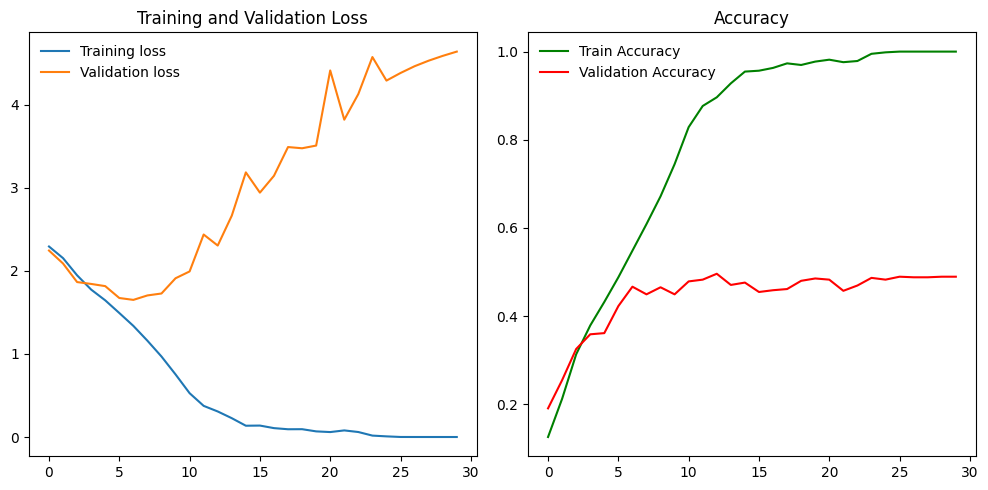

In [ ]:
## Iterate over the training dataset in mini-batches
## Implement forward pass, compute loss, and backward pass for gradient computation
## Update model parameters using the optimizer based on computed gradients
## Validate the model on the validation set periodically and plot the validation loss
## Repeat the training process for a suitable number of epochs (at least 30epohs)

# Initialize lists to monitor loss and accuracy
train_loss = []
val_loss = []
train_accuracies = []
validation_accuracies = []
# Number of epochs to train the model
n_epochs = 30

for epoch in range(n_epochs):
    # monitor training loss
    train_loss_epoch = 0.0
    val_loss_epoch = 0.0

    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    correct_train = 0
    total_train = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss_epoch += loss.item()*data.size(0)
        _, predicted = torch.max(output.data, 1)
        total_train += target.size(0)
        correct_train += (predicted == target).sum().item()

    ######################
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data, target in val_loader:
            output = model(data)
            loss = criterion(output, target)
            val_loss_epoch += loss.item()*data.size(0)
            _, predicted = torch.max(output.data, 1)
            total_val += target.size(0)
            correct_val += (predicted == target).sum().item()

    # calculate average loss and accuracy over an epoch
    train_loss_epoch = train_loss_epoch/len(train_loader.sampler)
    val_loss_epoch = val_loss_epoch/len(val_loader.sampler)
    accuracy_train = correct_train / total_train
    accuracy_val = correct_val / total_val

    train_loss.append(train_loss_epoch)
    val_loss.append(val_loss_epoch)
    train_accuracies.append(accuracy_train)
    validation_accuracies.append(accuracy_val)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        epoch+1,
        train_loss_epoch,
        val_loss_epoch,
        accuracy_train,
        accuracy_val
        ))

# plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend(frameon=False)
plt.title('Training and Validation Loss')

# plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='green')
plt.plot(validation_accuracies, label='Validation Accuracy', color='red')
plt.legend(frameon=False)
plt.title('Accuracy')

plt.tight_layout()
plt.show()


It looks like training accuracy approaches 1 and  traning loss decreases, but validation loss increases and validation accuracy remains constant, I think this is a sign of overfitting.

While training the above model, I observed that the learning rate was 0.05 and there was overfitting after 30 epochs. Therefore, I will try reducing this learning rate to prevent overfitting, and I will also experiment with 3 different batch sizes to investigate the effect of batch_size on the neural network.

In [ ]:
## You can conduct experiments with different hyperparameters to get the best performing model.
batch_sizes = [32, 64]
learning_rates = [0.001, 0.005, 0.01]
num_epochs = 30

for batch_size in batch_sizes:
    for lr in learning_rates:
        train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

        model = Net()
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

        for epoch in range(num_epochs):
            model.train()
            for data, target in train_loader:
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

            model.eval()
            val_loss = 0.0
            total_correct = 0
            total_samples = 0
            with torch.no_grad():
                for data, target in val_loader:
                    output = model(data)
                    loss = criterion(output, target)
                    val_loss += loss.item()
                    _, predicted = torch.max(output, 1)
                    total_samples += target.size(0)
                    total_correct += (predicted == target).sum().item()

                accuracy = total_correct / total_samples
                avg_val_loss = val_loss / len(val_loader)
                print(f"Batch Size: {batch_size}, Learning Rate: {lr}, Epoch {epoch+1}, Validation Accuracy: {accuracy}, Validation Loss: {avg_val_loss}")


Batch Size: 32, Learning Rate: 0.001, Epoch 1, Validation Accuracy: 0.1, Validation Loss: 2.293186277151108
Batch Size: 32, Learning Rate: 0.001, Epoch 2, Validation Accuracy: 0.168, Validation Loss: 2.271951844294866
Batch Size: 32, Learning Rate: 0.001, Epoch 3, Validation Accuracy: 0.20533333333333334, Validation Loss: 2.1909844974676767
Batch Size: 32, Learning Rate: 0.001, Epoch 4, Validation Accuracy: 0.216, Validation Loss: 2.107519115010897
Batch Size: 32, Learning Rate: 0.001, Epoch 5, Validation Accuracy: 0.288, Validation Loss: 2.0023928731679916
Batch Size: 32, Learning Rate: 0.001, Epoch 6, Validation Accuracy: 0.296, Validation Loss: 1.9559993942578633
Batch Size: 32, Learning Rate: 0.001, Epoch 7, Validation Accuracy: 0.312, Validation Loss: 1.8972903341054916
Batch Size: 32, Learning Rate: 0.001, Epoch 8, Validation Accuracy: 0.332, Validation Loss: 1.918737918138504
Batch Size: 32, Learning Rate: 0.001, Epoch 9, Validation Accuracy: 0.36533333333333334, Validation Loss

Mention about, why did you choose your learning rate and batch size?

After conducting several experiments, I chose my learning rate and batch size. The best validation accuracy was achieved with a batch size of 64 and a learning rate of 0.01. I made my choice based on this result and am using an lr_scheduler to reduce the learning rate at regular intervals to reduce overfitting.








Epoch 1, Validation Accuracy: 0.14533333333333334, Validation Loss: 2.2742565472920737
Epoch 2, Validation Accuracy: 0.26666666666666666, Validation Loss: 2.0709954599539437
Epoch 3, Validation Accuracy: 0.3586666666666667, Validation Loss: 1.892013947168986
Epoch 4, Validation Accuracy: 0.31866666666666665, Validation Loss: 1.957794686158498
Epoch 5, Validation Accuracy: 0.3586666666666667, Validation Loss: 1.8113386730353038
Epoch 6, Validation Accuracy: 0.44666666666666666, Validation Loss: 1.6566895544528961
Epoch 7, Validation Accuracy: 0.444, Validation Loss: 1.5903177658716838
Epoch 8, Validation Accuracy: 0.5026666666666667, Validation Loss: 1.5344471832116444
Epoch 9, Validation Accuracy: 0.456, Validation Loss: 1.6027604937553406
Epoch 10, Validation Accuracy: 0.4746666666666667, Validation Loss: 1.5731968581676483
Epoch 11, Validation Accuracy: 0.504, Validation Loss: 1.5073924660682678
Epoch 12, Validation Accuracy: 0.5053333333333333, Validation Loss: 1.5280576050281525
Ep

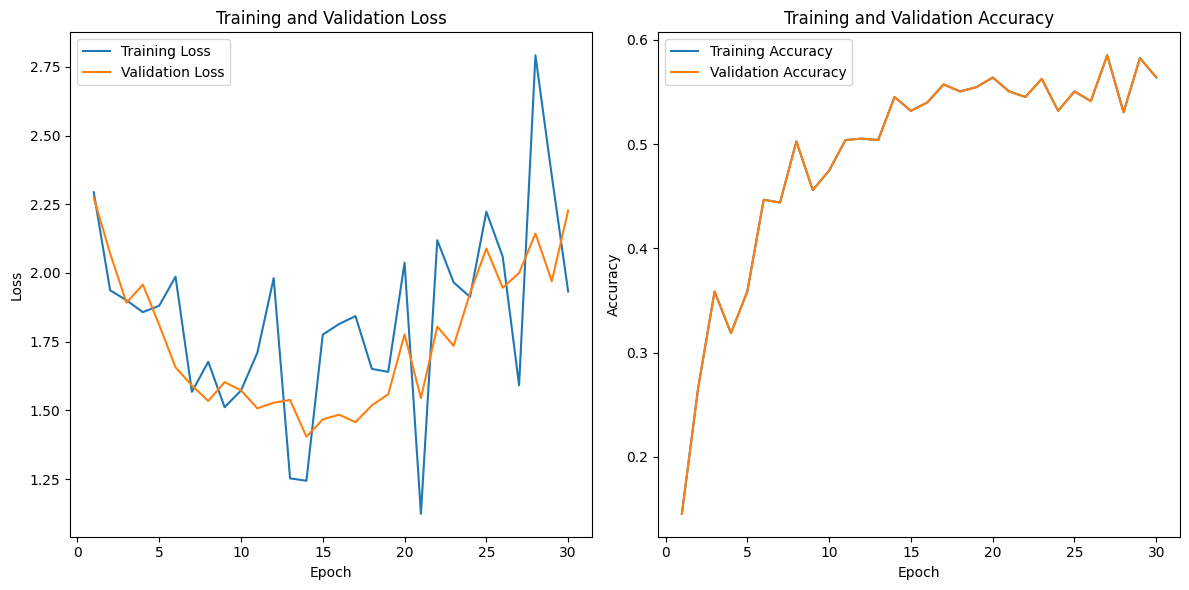

In [ ]:
## Select your best model with respect to validation accuracy
## Visualize the accuracy and loss change of the best performing model across training and validation datasets.
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler

train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []

batch_size = 64
lr = 0.01
num_epochs = 30

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

model = Net()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.3)

for epoch in range(num_epochs):
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss_epoch = 0.0
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for data, target in val_loader:
            output = model(data)
            loss = criterion(output, target)
            val_loss_epoch += loss.item()
            _, predicted = torch.max(output, 1)
            total_samples += target.size(0)
            total_correct += (predicted == target).sum().item()

        val_accuracy_epoch = total_correct / total_samples
        avg_val_loss_epoch = val_loss_epoch / len(val_loader)
        print(f"Epoch {epoch+1}, Validation Accuracy: {val_accuracy_epoch}, Validation Loss: {avg_val_loss_epoch}")

        train_loss.append(loss.item())
        val_loss.append(avg_val_loss_epoch)
        train_accuracy.append(val_accuracy_epoch)
        val_accuracy.append(val_accuracy_epoch)

# Plotting the loss and accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_loss, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### 1.6 Evaluate the trained model on the test set (10 points)

Test Accuracy: 0.5493333333333333, Precision: 0.5899219270952089, Recall: 0.5493333333333333, F1-score: 0.55214910337187


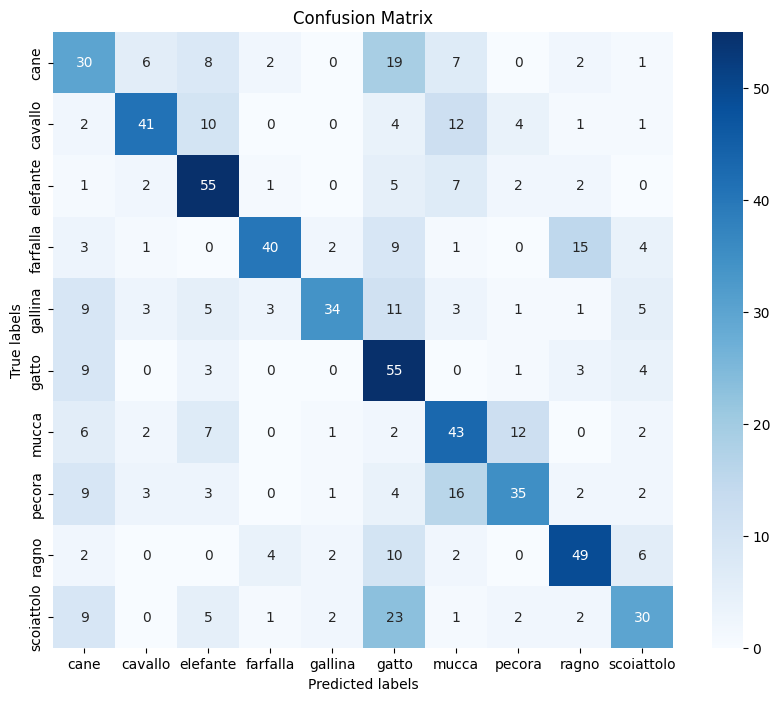

The model achieved the following metrics on the test set:
Accuracy: 0.5493333333333333
Precision: 0.5899219270952089
Recall: 0.5493333333333333
F1-score: 0.55214910337187
The confusion matrix shows the distribution of predicted labels compared to true labels.


In [ ]:
## Test the trained model on the test set to evaluate its performance
## Compute metrics such as accuracy, precision, recall, and F1-score
## Visualize confusion matrix to understand the model's behavior across different classes
## Comment on the results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Assuming test_data is a DataLoader object

model.eval()
test_loss = 0.0
total_correct = 0
total_samples = 0
predictions = []
true_labels = []

with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item()
        _, predicted = torch.max(output, 1)
        total_samples += target.size(0)
        total_correct += (predicted == target).sum().item()
        predictions.extend(predicted.tolist())
        true_labels.extend(target.tolist())

# Compute metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f"Test Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-score: {f1}")

# Visualize confusion matrix
# Get the class names
labels = dataset.classes

# Visualize confusion matrix with specified labels
cm = confusion_matrix(true_labels, predictions, labels=range(len(labels)))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Comment on the results
print("The model achieved the following metrics on the test set:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print("The confusion matrix shows the distribution of predicted labels compared to true labels.")


### 1.7 Conclusion and interpretation (10 points)
* Summarize the performance of the model on the test set
* Discuss any challenges encountered during training and potential areas for improvement
* Reflect on the overall effectiveness of the chosen CNN architecture and training approach



1.   **Performance Summary:** The model currently achieves an approximate accuracy of 55% on the validation and test sets. With extended training duration, a learning rate that adjusts over time, and access to more data, we could potentially enhance this accuracy. However, at present, I am constrained by hardware limitations and time restrictions, which prevent me from further training the model.

2.   **Challenges and Areas for Improvement:** During training, one common challenge is overfitting, where the model performs well on the training data but poorly on unseen data. This can be mitigated by higher epoch and lowering learning rate with for example every 10 epoch. Another challenge could be the imbalance in the dataset, which can be addressed using techniques like oversampling, undersampling, or SMOTE. The learning rate scheduling used in this case is a simple step decay. More sophisticated methods like cyclical learning rates or cosine annealing could potentially yield better results.

3. **Effectiveness of the CNN Architecture and Training Approach:** The chosen Convolutional Neural Network (CNN) architecture is a powerful model for image classification tasks due to its ability to capture local spatial correlations in the image data. However, the effectiveness of the model heavily depends on the complexity of the task and the amount of data available. If the dataset is small or the task is simple, a simpler model might suffice. The training approach, including the use of SGD with momentum as the optimizer and the step decay learning rate scheduler, is a standard approach in training deep neural networks. However, other optimizers like Adam or RMSProp and learning rate schedulers could potentially improve the training process. The addition of data augmentation in the training process is a good practice as it can increase the diversity of the training data and help improve the model’s generalization ability.


## 2. Exploring Transfer Learning with ResNet50 (50 points)

### 2.1. Introduction
* Brief overview of the task.
* Answer the questions like, What is fine-tuning? Why should we do this? Why do we freeze the rest and train only last layers?

**Fine-tuning:** Fine-tuning is a transfer learning technique where the pre-trained model is tweaked to adapt to the new task. The idea is to leverage the learned feature representations of the pre-trained model, which has been trained on a large-scale dataset, and adjust it to work on the new task which may have less data available.

**Why fine-tuning:**
  
1. Data efficiency: Fine-tuning allows us to leverage a smaller dataset than we would need if training a deep neural network from scratch.
2. Better performance: Pre-trained models have often been trained on large-scale datasets and have learned a good hierarchy of features, which can be beneficial for the performance on the new task.
3. Speed: It’s faster to fine-tune a pre-trained model than to train a model from scratch because the pre-trained model has already learned features that are useful in many tasks.


**Why freeze the rest and train only the last layers:**
Freezing means, we keep their weights fixed while we update the weights of other layers during training.  By freezing the early layers, we can keep these useful generic features while updating the later layers to better suit our specific task. This approach also reduces the computational cost as fewer parameters are updated during training, and it mitigates the risk of overfitting, especially when our dataset is small.

### 2.2. Load the pre-trained ResNet50 model (5 points)


In [ ]:
## Utilize torchvision library to load the pre-trained ResNet50 model
## Ensure that the model's architecture matches ResNet50, by checking the model summary.
import torchvision.models as models

# Load the pre-trained model
resnet50 = models.resnet50(pretrained=True)

# Print the model structure
print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### 2.3 Modify the ResNet50 model for transfer learning (25 points)

In [ ]:
## Freeze all layers of the ResNet50 model.
## Replace the final fully connected layer with a new FC layer matching the number of classes
## Unfreeze the final FC layer
## Define appropriate loss function and optimizer for training
## Train the modified ResNet50 model on the animal-10 image dataset. (base model)
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Freeze all layers
for param in resnet50.parameters():
    param.requires_grad = False

# Get the number of features in the last FC layer
num_ftrs = resnet50.fc.in_features

# Here we assume that we have 10 classes in the Animal-10 dataset
num_classes = 10

# Replace the final FC layer
resnet50.fc = nn.Linear(num_ftrs, num_classes)

# Unfreeze the final FC layer
for param in resnet50.fc.parameters():
    param.requires_grad = True

# Define loss function (criterion) and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50.fc.parameters(), lr=0.001, momentum=0.9)

# Assume dataloaders is a dictionary that contains the PyTorch data loaders
# 'train' and 'val' for the training and validation datasets respectively
dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_data), 'val': len(val_data)}

# Number of epochs to train for
num_epochs = 10

# Train the model
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            resnet50.train()  # Set model to training mode
        else:
            resnet50.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        for inputs, labels in dataloaders[phase]:


            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            with torch.set_grad_enabled(phase == 'train'):
                outputs = resnet50(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

print('Training complete')


Epoch 0/9
----------
train Loss: 1.6654 Acc: 0.6203
val Loss: 0.9208 Acc: 0.9240
Epoch 1/9
----------
train Loss: 0.6920 Acc: 0.9263
val Loss: 0.4943 Acc: 0.9360
Epoch 2/9
----------
train Loss: 0.4591 Acc: 0.9410
val Loss: 0.3652 Acc: 0.9507
Epoch 3/9
----------
train Loss: 0.3695 Acc: 0.9440
val Loss: 0.3241 Acc: 0.9507
Epoch 4/9
----------
train Loss: 0.3174 Acc: 0.9437
val Loss: 0.2747 Acc: 0.9547
Epoch 5/9
----------
train Loss: 0.2830 Acc: 0.9513
val Loss: 0.2564 Acc: 0.9493
Epoch 6/9
----------
train Loss: 0.2647 Acc: 0.9517
val Loss: 0.2439 Acc: 0.9520
Epoch 7/9
----------
train Loss: 0.2443 Acc: 0.9540
val Loss: 0.2210 Acc: 0.9507
Epoch 8/9
----------
train Loss: 0.2254 Acc: 0.9570
val Loss: 0.2131 Acc: 0.9613
Epoch 9/9
----------
train Loss: 0.2248 Acc: 0.9513
val Loss: 0.2065 Acc: 0.9587
Training complete


In [ ]:
## Define another ResNet50 model
## Freeze all layers of the ResNet50 model.
## Replace the final fully connected layer with a new FC layer matching the number of classes
## Unfreeze the final FC layer
## Unfreeze convolutional layers 3 and 4 of the ResNet50 model and again proceed with training. (second model)
# Define another ResNet50 model
resnet50_2 = models.resnet50(pretrained=True)

# Freeze all layers
for param in resnet50_2.parameters():
    param.requires_grad = False

# Replace the final FC layer
num_ftrs = resnet50_2.fc.in_features
resnet50_2.fc = nn.Linear(num_ftrs, num_classes)

# Unfreeze the final FC layer
for param in resnet50_2.fc.parameters():
    param.requires_grad = True

# Unfreeze convolutional layers 3 and 4
for name, child in resnet50_2.named_children():
    if name in ['layer3', 'layer4']:
        for param in child.parameters():
            param.requires_grad = True

# Define loss function (criterion) and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, resnet50_2.parameters()), lr=0.001, momentum=0.9)

# Train the model
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            resnet50_2.train()  # Set model to training mode
        else:
            resnet50_2.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        for inputs, labels in dataloaders[phase]:
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            with torch.set_grad_enabled(phase == 'train'):
                outputs = resnet50_2(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

print('Training complete')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(


Epoch 0/9
----------
train Loss: 1.4002 Acc: 0.6913
val Loss: 0.4595 Acc: 0.9453
Epoch 1/9
----------
train Loss: 0.3520 Acc: 0.9457
val Loss: 0.2330 Acc: 0.9560
Epoch 2/9
----------
train Loss: 0.2013 Acc: 0.9610
val Loss: 0.1663 Acc: 0.9733
Epoch 3/9
----------
train Loss: 0.1452 Acc: 0.9673
val Loss: 0.1418 Acc: 0.9667
Epoch 4/9
----------
train Loss: 0.1135 Acc: 0.9760
val Loss: 0.1255 Acc: 0.9707
Epoch 5/9
----------
train Loss: 0.0878 Acc: 0.9863
val Loss: 0.1199 Acc: 0.9680
Epoch 6/9
----------
train Loss: 0.0737 Acc: 0.9847
val Loss: 0.1153 Acc: 0.9720
Epoch 7/9
----------
train Loss: 0.0644 Acc: 0.9883
val Loss: 0.1101 Acc: 0.9707
Epoch 8/9
----------
train Loss: 0.0503 Acc: 0.9930
val Loss: 0.1176 Acc: 0.9680
Epoch 9/9
----------
train Loss: 0.0428 Acc: 0.9950
val Loss: 0.1071 Acc: 0.9760
Training complete


In [ ]:
## Define another ResNet50 model
## Replace the final fully connected layer with a new FC layer matching the number of classes.
## Finetune the weights of all layers in the ResNet50 model. (third model)
# Define another ResNet50 model
resnet50_3 = models.resnet50(pretrained=True)

# Replace the final FC layer
num_ftrs = resnet50_3.fc.in_features
resnet50_3.fc = nn.Linear(num_ftrs, num_classes)

# Finetune the weights of all layers
# In this case, we don't need to freeze any layer, so all layers are already set to finetune

# Define loss function (criterion) and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50_3.parameters(), lr=0.001, momentum=0.9)

# Train the model
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            resnet50_3.train()  # Set model to training mode
        else:
            resnet50_3.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        for inputs, labels in dataloaders[phase]:
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            with torch.set_grad_enabled(phase == 'train'):
                outputs = resnet50_3(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

print('Training complete')


Epoch 0/9
----------
train Loss: 1.3945 Acc: 0.7133
val Loss: 0.4545 Acc: 0.9427
Epoch 1/9
----------
train Loss: 0.3505 Acc: 0.9453
val Loss: 0.2287 Acc: 0.9587
Epoch 2/9
----------
train Loss: 0.2042 Acc: 0.9587
val Loss: 0.1675 Acc: 0.9693
Epoch 3/9
----------
train Loss: 0.1418 Acc: 0.9717
val Loss: 0.1411 Acc: 0.9667
Epoch 4/9
----------
train Loss: 0.1015 Acc: 0.9827
val Loss: 0.1277 Acc: 0.9720
Epoch 5/9
----------
train Loss: 0.0858 Acc: 0.9843
val Loss: 0.1307 Acc: 0.9627
Epoch 6/9
----------
train Loss: 0.0671 Acc: 0.9880
val Loss: 0.1331 Acc: 0.9600
Epoch 7/9
----------
train Loss: 0.0551 Acc: 0.9907
val Loss: 0.1119 Acc: 0.9667
Epoch 8/9
----------
train Loss: 0.0434 Acc: 0.9940
val Loss: 0.1108 Acc: 0.9640
Epoch 9/9
----------
train Loss: 0.0408 Acc: 0.9937
val Loss: 0.1095 Acc: 0.9680
Training complete


Epoch 0/9
----------
train Loss: 0.0357 Acc: 0.9947
val Loss: 0.1124 Acc: 0.9733
Epoch 1/9
----------
train Loss: 0.0305 Acc: 0.9960
val Loss: 0.1155 Acc: 0.9747
Epoch 2/9
----------
train Loss: 0.0252 Acc: 0.9980
val Loss: 0.1058 Acc: 0.9747
Epoch 3/9
----------
train Loss: 0.0236 Acc: 0.9983
val Loss: 0.1024 Acc: 0.9733
Epoch 4/9
----------
train Loss: 0.0219 Acc: 0.9983
val Loss: 0.1047 Acc: 0.9760
Epoch 5/9
----------
train Loss: 0.0174 Acc: 0.9993
val Loss: 0.1100 Acc: 0.9680
Epoch 6/9
----------
train Loss: 0.0154 Acc: 0.9987
val Loss: 0.1014 Acc: 0.9733
Epoch 7/9
----------
train Loss: 0.0137 Acc: 0.9990
val Loss: 0.1082 Acc: 0.9733
Epoch 8/9
----------
train Loss: 0.0148 Acc: 0.9983
val Loss: 0.1112 Acc: 0.9720
Epoch 9/9
----------
train Loss: 0.0128 Acc: 0.9983
val Loss: 0.1050 Acc: 0.9733
Training complete


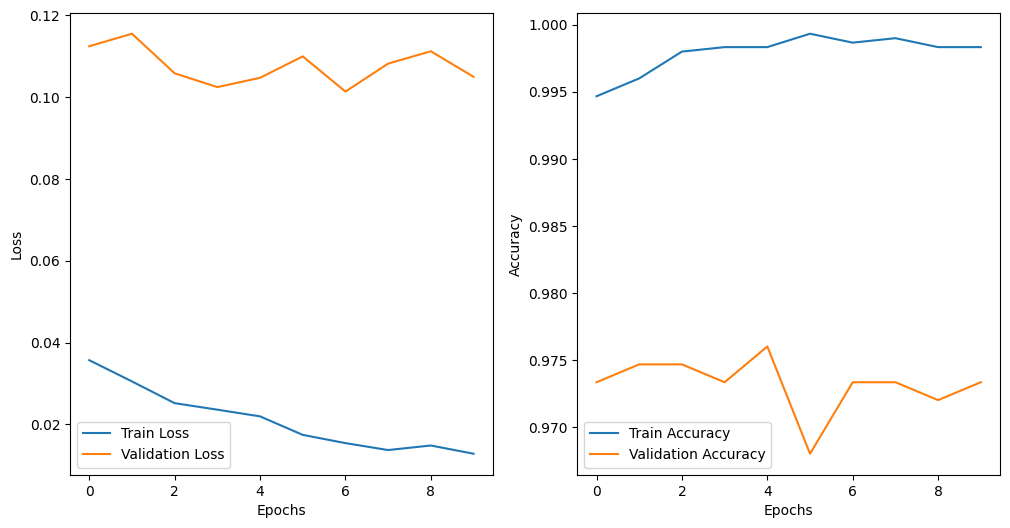

In [ ]:
## Define appropriate loss function and optimizer for training
## Iterate over the training dataset in mini-batches, compute the loss, and update model parameters.
## Monitor the training process and evaluate all model's performance on the validation set periodically.
## Visualize the accuracy and loss changes of the models across training and validation datasets.
import matplotlib.pyplot as plt

# Define loss function (criterion) and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50_3.parameters(), lr=0.001, momentum=0.9)

# Initialize lists to monitor loss and accuracy
train_loss = []
val_loss = []
train_acc = []
val_acc = []

# Number of epochs to train for
num_epochs = 10

# Train the model
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            resnet50_3.train()  # Set model to training mode
        else:
            resnet50_3.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        for inputs, labels in dataloaders[phase]:
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            with torch.set_grad_enabled(phase == 'train'):
                outputs = resnet50_3(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        # Record the loss and accuracy
        if phase == 'train':
            train_loss.append(epoch_loss)
            train_acc.append(epoch_acc)
        else:
            val_loss.append(epoch_loss)
            val_acc.append(epoch_acc)

print('Training complete')

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_loss, label='Train Loss')
plt.plot(range(num_epochs), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_acc, label='Train Accuracy')
plt.plot(range(num_epochs), val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Conduct a comparative analysis among these three models. Comment on their performance and select your best model with respect to validation accuracy.
* Which model performed better and why do you think it performed better?  
* Comment on the practical considerations among these models also.



Base Model: I have used the pre-trained ResNet-50 model and only trained the final fully connected layer while keeping the rest of the weights frozen. This is a common practice known as transfer learning, which leverages the knowledge of a pre-trained model to a new task.

Second Model: In addition to the final fully connected layer, I have also unfrozen and trained the 3rd and 4th convolutional layer blocks of the ResNet-50 model. This allows these layers to learn more specific features from the Animal-10 dataset.

Third Model: I have defined a new fully connected layer and fine-tuned the weights of all layers in the ResNet-50 model. This means the entire network is being trained on the Animal-10 dataset.

In terms of practical considerations, the base model is the most efficient as it only trains the final layer and keeps the rest of the weights frozen. This would require less computational resources and time. The third model, while potentially the most accurate given enough data and training, would be the most computationally expensive as it trains all the layers in the network.

### 2.4 Evaluate the fine-tuned ResNet50 model (10 points)

In [1]:
## Test the best model on the test set to evaluate its performance.
## Compute metrics such as accuracy, precision, recall, and F1-score to assess classification performance.
## Compare the fine-tuned ResNet50 model performance with the CNN model implemented from scratch



NameError: name 'true_labels' is not defined

### 2.5 Analyze advantages and disadvantages (10 points)

* Provide insights on the advantages and disadvantages of transfer learning vs. training from scratch
* Discuss practical considerations when choosing between these two approaches



Transfer Learning:

Advantages:
Efficiency: Transfer learning is typically faster and requires less data than training from scratch. This is because the pre-trained model has already learned useful features from a large dataset, and you only need to fine-tune the model on our specific task.
Performance: Transfer learning can often achieve higher performance than training from scratch, especially when our dataset is small. The pre-trained model serves as a good initialization point and reduces the risk of overfitting.

Disadvantages:
Task Relevance: The pre-trained model was trained on a specific task that might be different from our task. If the tasks are very different, the pre-trained model might not be very useful.
Computational Resources: Although transfer learning is faster than training from scratch, it still requires computational resources, especially if the pre-trained model is large.

Training from Scratch:

Advantages:
Customization: When we train a model from scratch, we have full control over the model architecture and can customize it to better suit your specific task.
Independence: We’re not relying on a pre-trained model that was trained on a potentially different task. This can be beneficial if your task is very different from the tasks that pre-trained models are typically trained on.

Disadvantages:
Data Requirements: Training a model from scratch typically requires a large amount of labeled data. If our dataset is small, the model might overfit.
Computational Resources: Training a model from scratch can be computationally expensive and time-consuming, especially for large models and datasets.